<a href="https://colab.research.google.com/github/Gail529/Mental-health/blob/main/lstm_MH_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd 
import numpy as np
import gensim
import os
import tweepy as tw
 
#tweet preprocessing 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import re
from keras import backend as K
from tensorflow.keras.models import Model, load_model
from nltk.tokenize import word_tokenize,sent_tokenize,TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
 
 
 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
 

import pickle 
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data=pd.read_csv('/content/Mental_health2.csv')

In [5]:
data.head(2)


,Unnamed: 0,tweets,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,afinn_score,positive_vader,negative_vader,neutral_vader,depression_score
0,0,i love my family i love my life happiness,3,0,0,1,0,0,3,0,0,0,9.0,0.667,0.0,0.333,21.3395
1,1,homosexual will not inherit the kingdom of go...,1,0,0,1,0,1,1,0,1,1,1.0,0.104,0.0,0.896,25.7540


In [6]:
#lowercasing and url,punctuations and numbers removal,
def Lowercasing(words):
    string=re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "",str(words))
    word=string.lower()
    return word

#Tokenization and (@)handle extraction
def Tokenization(tweet):
    tokenizer=TweetTokenizer(strip_handles=True)
    tokens = tokenizer.tokenize(tweet)
    return tokens

#punctuations
def Punctuation_removal(tokens):
    words=[ word for word in tokens if word.isalnum()]
    return words

#stemming
def stemming(text):
    stemmer=PorterStemmer()
    for  word in text:
        stemmed_words=stemmer.stem(word)
        return stemmed_words

#stopword_removal
def remove_stopwords(words):
    stop_words=set(stopwords.words("english")) 
    result=[word for word in words if word not in stop_words ]
    return result


#lemmatization
def lemmatization(text):
    lemmatizer=WordNetLemmatizer()
    lemmatized_phrase=[]
    for word in text:
        lemmatized_word=lemmatizer.lemmatize(word)
        lemmatized_phrase.append(lemmatized_word)
    return lemmatized_phrase
 

In [7]:
#code for cleaning a simple tweet
def clean_tweet(tweet):
    tweet_tokens=Tokenization(tweet)
    lemmatized_tweet=lemmatization(tweet_tokens)#lemmatization
    lowercased_string=Lowercasing(lemmatized_tweet)#lowercasing and removing numbers
    return lowercased_string


Tokenizing the tweet

In [8]:
tweets=data['tweets'].values.tolist()
len(tweets)

1904

In [11]:
tweet_list=[]
for tweet in tweets:
    tokens =  word_tokenize(tweet)
    #stop_words=set(stopwords.words("english")) 
    #word=[word for word in tokens if word not in stop_words]
    tweet_list.append(tokens)

    

Training the word2vec Model

In [12]:
EMBEDDING_DIM=100
model = gensim.models.Word2Vec(sentences=tweet_list,size=EMBEDDING_DIM,window=5,workers=4,min_count=1)
words = list(model.wv.vocab)
print('Vocabulary size: %d',len(words))
print(words)

Vocabulary size: %d 4381
['i', 'love', 'my', 'family', 'life', 'happiness', 'homosexual', 'will', 'not', 'inherit', 'the', 'kingdom', 'of', 'god', 'right', 'so', 'guess', 'your', 'homphobic', 'mom', 'we', 'r', 'here', 'to', 'shower', 'our', 'unconditional', 'n', 'alwys', 'felt', 'they', 'both', 'a', 'wanted', 'you', 'are', 'and', 'always', 'be', 'for', 'ever', 'bts', 'praying', 'almighty', 'with', 'good', 'health', 'bountiful', 'patience', 'positivity', 'peace', 'fa', 'worked', 'hard', 'improve', 'on', 'or', 'correct', 'entirely', 'promote', 'self', 'value', 'integrity', 'work', 'persi', 'true', 'me', 'make', 'it', 'happen', 'heart', 'get', 'into', 'place', 'done', 'in', 'future', 'want', 'queen', 'who', 'isn', 't', 'trying', 'live', 'her', 'others', 'market', 'herself', 'like', 'she', 's', 'single', 'time', 'back', 'again', 'together', 'celebrate', 'while', 'serve', 'thing', 'know', 'where', 'do', 'believe', 'eye', 'especially', 'when', 'entertaining', 'those', 'take', 'care', 'truly'

In [13]:
model.wv.most_similar('depression')

[('diagnosed', 0.9999277591705322),
 ('wa', 0.9999120235443115),
 ('anxiety', 0.999897301197052),
 ('with', 0.9998953342437744),
 ('been', 0.999894380569458),
 ('i', 0.9998931884765625),
 ('got', 0.9998847246170044),
 ('adhd', 0.9998801946640015),
 ('disorder', 0.9998561143875122),
 ('just', 0.9998427629470825)]

Saving the word2vec model

In [15]:
filename = 'tweets_embedding.txt'
model.wv.save_word2vec_format(filename,binary=False)

Preparing Train and Test Data


In [16]:
def prep_tokenizer(tweet_list):
    #instantiating the tokenizing object -creating a unique word dictionary ,where unique words are rep. as sentences
    tokenizer = Tokenizer()
    #fitting it into the text
    tokenizer.fit_on_texts(tweet_list)
    #saving the tokenizing object
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Tokeniser saved')
    
def prepare_data(tweet_list,tokenizer):
   #creating a list of tokens for each tweet (A list of lists)
   sequences = tokenizer.texts_to_sequences(tweet_list)
   word_index = tokenizer.word_index
   print('Vocabulary size:', len(word_index))
   max_length = max([len(s.split()) for s in tweets])
   tweet_pad =pad_sequences(sequences,maxlen=max_length)
   return tweet_pad

 

In [17]:
import pickle 
import os
import re

prep_tokenizer(tweet_list)
with open('tokenizer.pickle', 'rb') as handle:
   tokenizer = pickle.load(handle)

tweet_pad = prepare_data(tweet_list,tokenizer)

Tokeniser saved
Vocabulary size: 4381


In [18]:
sequences = tokenizer.texts_to_sequences(tweet_list)
word_index = tokenizer.word_index

In [20]:
emotion_score=data['depression_score'].values
VALIDATION_SPLIT = 0.2
indices = np.arange(tweet_pad.shape[0])
np.random.shuffle(indices)
tweet_pad = tweet_pad[indices]
emotion_score = emotion_score[indices]

num_validation_samples = int(VALIDATION_SPLIT * tweet_pad.shape[0])

x_train_pad = tweet_pad[:-num_validation_samples]
y_train = emotion_score[:-num_validation_samples]
x_test_pad = tweet_pad[-num_validation_samples:]
y_test = emotion_score[-num_validation_samples:]

In [ ]:
emotion_score=data['label'].values

VALIDATION_SPLIT = 0.2
indices = np.arange(tweet_pad.shape[0])
np.random.shuffle(indices)
tweet_pad = tweet_pad[indices]
emotion_score = emotion_score[indices]

num_validation_samples = int(VALIDATION_SPLIT * tweet_pad.shape[0])

x_train_pad = tweet_pad[:-num_validation_samples]
y_train = emotion_score[:-num_validation_samples]
x_test_pad = tweet_pad[-num_validation_samples:]
y_test = emotion_score[-num_validation_samples:]

In [21]:
x_train_pad = np.asarray(x_train_pad).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test_pad = np.asarray(x_test_pad).astype(np.float32)
y_test= np.asarray(y_test).astype(np.float32)


print(len(x_test_pad))
print(len(x_train_pad))
print(len(y_train))
print(len(y_test))

380
1524
1524
380


In [22]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_test))


Counter({48.109: 23, 2.5: 21, 0.0: 17, 21.0015: 7, 8.21: 7, 47.7325: 6, 24.932: 5, 63.5975: 4, 7.5: 4, 47.14: 4, 47.155: 4, 335.9425: 4, 3.5: 4, 47.57: 4, 129.025: 4, 48.16: 4, 47.2075: 4, 81.892: 4, 47.275: 4, 128.96: 3, 47.645: 3, 47.1875: 3, 46.4575: 3, 11.35: 3, 33.4235: 3, 23.766: 3, 73.161: 3, 47.8425: 3, 49.312: 3, 63.6245: 3, 47.3025: 3, 82.8485: 2, 48.46: 2, 41.103: 2, 9.253: 2, 140.655: 2, 35.7975: 2, 47.5075: 2, 47.41: 2, 67.146: 2, 41.42: 2, 47.9825: 2, 35.8595: 2, 50.295: 2, 128.9075: 2, 131.0725: 2, 6.07: 2, 4.2855: 2, 58.3955: 2, 47.4305: 2, 50.8725: 2, 26.224: 2, 32.902: 2, 27.7575: 2, 26.3995: 2, 24.1995: 2, 47.1175: 2, 22.2385: 2, 53.9695: 2, 21.2405: 2, 63.805: 2, 47.25: 2, 21.021: 2, 34.7015: 2, 48.3345: 2, 128.9325: 2, 24.911: 2, 61.345: 2, 4.64: 2, 131.0475: 2, 44.5225: 2, 7.9595: 2, 48.0625: 2, 71.0475: 2, 51.14: 2, 20.965: 1, 19.4075: 1, 97.265: 1, 143.451: 1, 128.892: 1, 92.3125: 1, 18.8015: 1, 51.072: 1, 16.63: 1, 52.86: 1, 21.2015: 1, 90.364: 1, 9.0035: 1, 13

Creating the Embedding layer

In [23]:
import os
embeddings_index = {}
f = open(os.path.join('','tweets_embedding.txt'),encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()    

Embedding Matrix

In [24]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))

for word,i in word_index.items():
    if i > num_words:
        continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
print(num_words)

4909


In [ ]:
def get_class_model():
    model = Sequential()
    model.add(Embedding(num_words ,EMBEDDING_DIM))
    model.add(LSTM(1, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam' , metrics=['accuracy'])

model=get_model2()


In [32]:
import tensorflow as tf
from tensorflow import keras

In [35]:
def get_reg_model():
    model = keras.Sequential()
    model.add(Embedding(num_words ,EMBEDDING_DIM))
    model.add(LSTM(1, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

model=get_reg_model()


Model Training Finally....

In [36]:
model.fit(x_train_pad, y_train, batch_size=10, epochs=20,validation_data=(x_test_pad, y_test))


Epoch 1/20
153/153 [==============================] - 4s 17ms/step - loss: 6979.5439 - mae: 62.8913 - val_loss: 7165.8052 - val_mae: 62.5990
Epoch 2/20
153/153 [==============================] - 2s 15ms/step - loss: 6926.0566 - mae: 62.4949 - val_loss: 7119.3711 - val_mae: 62.2298
Epoch 3/20
153/153 [==============================] - 2s 15ms/step - loss: 6882.2837 - mae: 62.1188 - val_loss: 7076.5664 - val_mae: 61.8910
Epoch 4/20
153/153 [==============================] - 2s 15ms/step - loss: 6844.3696 - mae: 61.8323 - val_loss: 7037.7314 - val_mae: 61.5828
Epoch 5/20
153/153 [==============================] - 2s 15ms/step - loss: 6797.7578 - mae: 61.4865 - val_loss: 6999.3428 - val_mae: 61.2778
Epoch 6/20
153/153 [==============================] - 2s 15ms/step - loss: 6769.9297 - mae: 61.1901 - val_loss: 6963.9761 - val_mae: 60.9946
Epoch 7/20
153/153 [==============================] - 2s 16ms/step - loss: 6725.8647 - mae: 60.9000 - val_loss: 6928.6060 - val_mae: 60.7115
Epoch 8/20
15

In [37]:
model.save('MH2_reg_model.h5')

In [39]:
reconstructed_model = keras.models.load_model('/content/MH2_reg_model.h5')

In [43]:
model=load_model('/content/MH2_reg_model.h5')
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

data = clean_tweet('scary days are the worst')
seq=tokenizer.texts_to_sequences(data)
data = pad_sequences(seq,maxlen=200)
prediction=np.argmax(model.predict(data),axis=1)
output=model.predict(data)
output

array([[6.142847 ],
       [6.1428204],
       [6.1429157],
       [6.0990944],
       [6.1425996],
       [6.142913 ],
       [6.1428604],
       [6.1429157],
       [6.1425996],
       [6.142913 ],
       [6.1429157],
       [6.0990944],
       [6.142397 ],
       [6.142913 ],
       [6.1428967],
       [6.1427107],
       [6.142397 ],
       [6.142913 ],
       [6.1428165],
       [6.1428323],
       [6.0990944],
       [6.142847 ],
       [6.1428967]], dtype=float32)

In [ ]:
data=pd.read_csv('/content/Mental_health.csv')

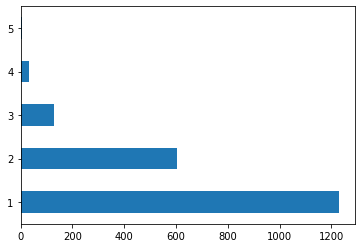

In [ ]:
data['labels'].value_counts().plot(kind='barh')

In [ ]:

prediction=model.predict(data)
prediction_class = prediction.argmax(axis=-1)[0][0]
print(prediction_class)

1


# Streamlit code


In [ ]:
!pip install streamlit

     |████████████████████████████████| 8.2MB 5.2MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 112kB 46.8MB/s 
     |████████████████████████████████| 174kB 43.0MB/s 
     |████████████████████████████████| 4.2MB 34.1MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 122kB 41.8MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp37-none-any.whl size=13476 sha256=bb79f392b6daa6f99c3850cdce7d385a35cce5488805dcccae40c84307375e91
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
Successfully built blinker
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [ ]:
from keras import backend as K
from tensorflow.keras.models import Model, load_model
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

wordnet = WordNetLemmatizer()
regex = re.compile('[%s]' % re.escape(string.punctuation))


In [ ]:
MODEL_PATH = '/content/MH/saved_model.pb'
MAX_NB_WORDS = 100000 # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2 # data for validation (not used in training)
EMBEDDING_DIM = 100
tokenizer_file = 'tokenizer.pickle'

In [ ]:
with open(tokenizer_file, 'rb') as handle:
   tokenizer = pickle.load(handle)
@st.cache(allow_output_mutation=True)
def Load_model():
   model = reconstructed_model
   model.summary() # included to make it visible when model is reloaded
   session = K.get_session()
   return model, session

   Load_model

In [ ]:
#@st.cache
#def load_my_model():
model = reconstructed_model
 

if __name__ == '__main__':
    st.title('A simple streamlit mental health app')
    st.write('Want to know if your tweets contain some depressive characteristics')
    st.subheader('Key in or paste one of your tweets') 
    tweet=st.text_area('') 
    prediction_btn = st.button('predict')
    if prediction_btn:
        clean_text = []
        #K.set_session(session)
        i = clean_tweet(tweet)
        clean_text.append(i)
        sequences = tokenizer.texts_to_sequences(clean_text)
        data = pad_sequences(sequences, maxlen = max_length)
        prediction = model.predict(data)

In [ ]:
if prediction_btn:
   clean_text = []
   K.set_session(session)
   i = clean_tweet(tweet)
   clean_text.append(i)
   sequences = tokenizer.texts_to_sequences(clean_text)
   data = pad_sequences(sequences, maxlen = max_length)
   prediction = model.predict(data)

In [ ]:
prediction_class = prediction.argmax(axis=-1)[0]


st.header("Prediction using LSTM model")
if prediction_class == 0:
    st.success()
if prediction_class == 1:
    st.success()
if prediction_class == 2:
    st.success()
if prediction_class == 3:
    st.success()
if prediction_class == 4:
    st.success()

In [ ]:
if __name__ == '__main__':
    st.title('A simple streamlit mental health app')
    st.write('Want to know if your tweets contain some depressive characteristics')
    st.subheader('Key in or paste one of your tweets') 
    tweet=st.text_area('') 
    prediction_btn = st.button('predict')
    model= Load_model()


InternalHashError: ignored